In [1]:
#This program fits the O-PPAC data onto a FCNN model
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import datetime

In [2]:
dataset = h5py.File('simu_HDF.h5', 'r')
num_diodes = dataset['Num_diodes'][...]
x_pos = (dataset['Xpos'][...])/100
y_pos = (dataset['Ypos'][...])/100
histgrid = dataset['histgrid'][...]
output = np.vstack((x_pos,y_pos))
output = np.transpose(output)

where_are_NaNs = isnan(histgrid)
histgrid[where_are_NaNs] = 0

dataset.close()
#print(histgrid)
#print(output)

In [3]:
histgrid.shape

(342, 132, 1001)

In [4]:
histgrid[0,0:132,0]

array([  0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   7.,  24.,
        58.,  82.,  57.,  29.,   5.,   0.,   2.,   1.,   0.,   1.,   0.,
         0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,   6.,
        71., 110.,  95.,   5.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   7.,  36.,
        47.,  61.,  71.,  20.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,
         2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   7.,
        57., 124.,  54.,  10.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [5]:
#Testing lists vs arrays
all_data = []
labels = []
for i in range(343):
    all_data.append(i)
    labels.append(i)

In [6]:
def data_compile(histdata):
    data = []
    labels = []
    for i in range(histdata.shape[0]):
        for j in range(1,histdata.shape[2]):
            data.append(histdata[i,0:132,j])
            labels.append(output[i])
    return(np.array(data),np.array(labels))

all_data, all_labels = data_compile(histgrid)
all_data.reshape(-1,1)

array([[0.00000000e+000],
       [0.00000000e+000],
       [1.00000000e+000],
       ...,
       [6.35192734e-269],
       [2.03268160e-068],
       [9.00829169e-312]])

In [36]:
all_data = normalize(all_data,axis = 1)
max_value = np.amax(all_data)
print(max_value)
#no need to normalize if max == 1 ??

1.0


In [37]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size=0.2,shuffle=True)

In [38]:
train_data.ndim

2

In [39]:
train_data.shape

(273600, 132)

In [40]:
train_data[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00367771, 0.        , 0.        , 0.        ,
       0.        , 0.01838857, 0.19491882, 0.46339191, 0.37144907,
       0.08458741, 0.00367771, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00735543, 0.        , 0.        ,
       0.        , 0.        , 0.23537367, 0.54797932, 0.00367771,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00367771, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00735543, 0.        , 0.        , 0.00367771, 0.        ,
       0.        , 0.00367771, 0.03309942, 0.0809097 , 0.12504226,
       0.13239769, 0.19491882, 0.13975311, 0.05148799, 0.04413

In [41]:
log_dir = "logs/fit/" + "O-PPAC_FCNN" + "RMSprop0.001,mse,no_dropout,1dense128,relu"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 0)

In [42]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [43]:
FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
#FCNN_model.add(layers.Dropout(0.5))
FCNN_model.add(layers.Dense(2, activation = 'linear'))

In [44]:
FCNN_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), 
              loss = 'mse', 
              metrics=['mae', 'mse'])

In [45]:
FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs=100,
                    batch_size = 32,
                    callbacks = [callback],
                    validation_split = 0.3 
                    )

Epoch 1/100
5985/5985 [==============================] - 19s 3ms/step - loss: 20.7656 - mae: 2.5690 - mse: 20.7656 - val_loss: 2.8692 - val_mae: 1.2141 - val_mse: 2.8692
Epoch 2/100
5985/5985 [==============================] - 16s 3ms/step - loss: 2.5239 - mae: 1.1339 - mse: 2.5239 - val_loss: 2.0949 - val_mae: 1.0276 - val_mse: 2.0949
Epoch 3/100
5985/5985 [==============================] - 16s 3ms/step - loss: 1.7505 - mae: 0.9403 - mse: 1.7505 - val_loss: 1.3353 - val_mae: 0.7976 - val_mse: 1.3353
Epoch 4/100
5985/5985 [==============================] - 20s 3ms/step - loss: 1.4144 - mae: 0.8361 - mse: 1.4144 - val_loss: 1.3151 - val_mae: 0.8038 - val_mse: 1.3151
Epoch 5/100
5985/5985 [==============================] - 18s 3ms/step - loss: 1.2081 - mae: 0.7665 - mse: 1.2081 - val_loss: 1.3148 - val_mae: 0.8245 - val_mse: 1.3148
Epoch 6/100
5985/5985 [==============================] - 18s 3ms/step - loss: 1.0743 - mae: 0.7177 - mse: 1.0743 - val_loss: 1.1857 - val_mae: 0.7781 - val_ms

5985/5985 [==============================] - 16s 3ms/step - loss: 0.3274 - mae: 0.3657 - mse: 0.3274 - val_loss: 0.3478 - val_mae: 0.3595 - val_mse: 0.3478
Epoch 50/100
5985/5985 [==============================] - 16s 3ms/step - loss: 0.3223 - mae: 0.3641 - mse: 0.3223 - val_loss: 0.4399 - val_mae: 0.4455 - val_mse: 0.4399
Epoch 51/100
5985/5985 [==============================] - 16s 3ms/step - loss: 0.3238 - mae: 0.3622 - mse: 0.3238 - val_loss: 0.3862 - val_mae: 0.3962 - val_mse: 0.3862
Epoch 52/100
5985/5985 [==============================] - 16s 3ms/step - loss: 0.3172 - mae: 0.3603 - mse: 0.3172 - val_loss: 0.3636 - val_mae: 0.3680 - val_mse: 0.3636
Epoch 53/100
5985/5985 [==============================] - 17s 3ms/step - loss: 0.3153 - mae: 0.3586 - mse: 0.3153 - val_loss: 0.3411 - val_mae: 0.3535 - val_mse: 0.3411
Epoch 54/100
5985/5985 [==============================] - 17s 3ms/step - loss: 0.3142 - mae: 0.3569 - mse: 0.3142 - val_loss: 0.3458 - val_mae: 0.3626 - val_mse: 0.3458

5985/5985 [==============================] - 16s 3ms/step - loss: 0.2485 - mae: 0.3108 - mse: 0.2485 - val_loss: 0.3192 - val_mae: 0.3301 - val_mse: 0.3192
Epoch 98/100
5985/5985 [==============================] - 16s 3ms/step - loss: 0.2478 - mae: 0.3099 - mse: 0.2478 - val_loss: 0.3022 - val_mae: 0.3193 - val_mse: 0.3022
Epoch 99/100
5985/5985 [==============================] - 16s 3ms/step - loss: 0.2468 - mae: 0.3096 - mse: 0.2468 - val_loss: 0.2938 - val_mae: 0.3196 - val_mse: 0.2938
Epoch 100/100
5985/5985 [==============================] - 17s 3ms/step - loss: 0.2472 - mae: 0.3087 - mse: 0.2472 - val_loss: 0.3743 - val_mae: 0.3839 - val_mse: 0.3743


Text(0.5, 1.0, 'FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, RMSprop 0.001, MSE, linear activation')

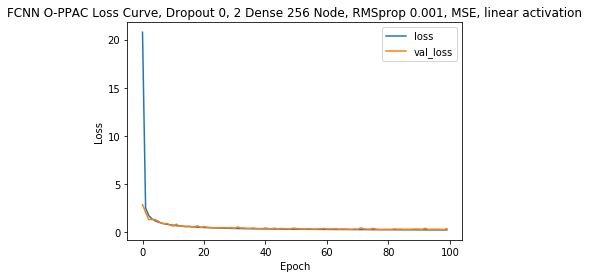

In [48]:
plt.plot(FCNN_history.history['loss'], label='loss')
plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 3.5])
plt.legend(loc='upper right')
plt.title("FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, RMSprop 0.001, MSE, linear activation")

In [47]:
result = FCNN_model.evaluate(test_data, test_labels, verbose=2)

2138/2138 - 2s - loss: 0.4344 - mae: 0.3865 - mse: 0.4344


In [49]:
predictions = FCNN_model.predict(test_data)

In [50]:
x_pred = predictions[:,0]
y_pred = predictions[:,1]


x_test1 = [i[0] for i in test_labels]
y_test1 = [i[1] for i in test_labels]

x_test = np.array(x_test1)
y_test = np.array(y_test1)

In [72]:
x_train1 = [i[0] for i in train_labels]
y_train1 = [i[1] for i in train_labels]

x_train = np.array(x_train1)
y_train = np.array(y_train1)

In [73]:
print(x_train.shape)

(273600,)


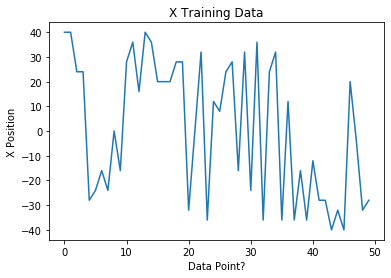

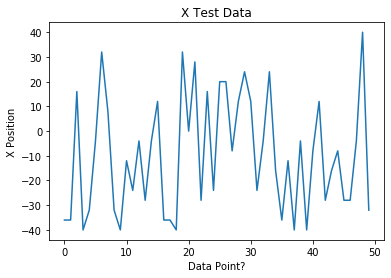

In [76]:
train_histogram_x = []
for i in range(50):
    train_histogram_x.append([x_train[i]])    
np.array(train_histogram_x)

#set_size(5,3)
#plt.axis([0, 132, 0, 160])
plt.title('X Training Data')
plt.xlabel('Data Point?')
plt.ylabel('X Position')
plt.plot(train_histogram_x)
plt.show()

test_histogram_x = []
for i in range(50):
    test_histogram_x.append([x_test[i]])    
np.array(test_histogram_x)

#set_size(5,3)
#plt.axis([0, 132, 0, 160])
plt.title('X Test Data')
plt.xlabel('Data Point?')
plt.ylabel('X Position')
plt.plot(test_histogram_x)
plt.show()

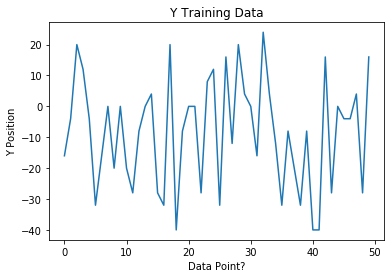

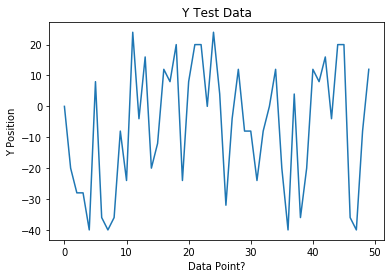

In [69]:
train_histogram_y = []
for i in range(50):
    train_histogram_y.append([y_train[i]])    
np.array(train_histogram_y)

#set_size(5,3)
#plt.axis([0, 132, 0, 160])
plt.title('Y Training Data')
plt.xlabel('Data Point?')
plt.ylabel('Y Position')
plt.plot(train_histogram_y)
plt.show()

test_histogram_y = []
for i in range(50):
    test_histogram_y.append([y_test[i]])    
np.array(test_histogram_y)

#set_size(5,3)
#plt.axis([0, 132, 0, 160])
plt.title('Y Test Data')
plt.xlabel('Data Point?')
plt.ylabel('Y Position')
plt.plot(test_histogram_y)
plt.show()

In [78]:
new_x_labels = []
for i in range(x_test.shape[0]):
    new_x_labels.append([x_test[i]])
np.array(new_x_labels)
new_x_labels[2]

[16.0]

Text(0.5, 1.0, 'FCNN O-PPAC X Predictions vs True X Values')

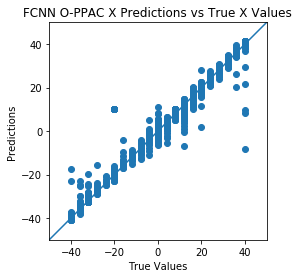

In [79]:
a = plt.axes(aspect='equal')
plt.scatter(new_x_labels, x_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title("FCNN O-PPAC X Predictions vs True X Values")

In [80]:
new_y_labels = []
for i in range(y_test.shape[0]):
    new_y_labels.append([y_test[i]])
np.array(new_y_labels)
new_y_labels[2]

[-28.0]

Text(0.5, 1.0, 'FCNN O-PPAC Y Predictions vs True Y Values')

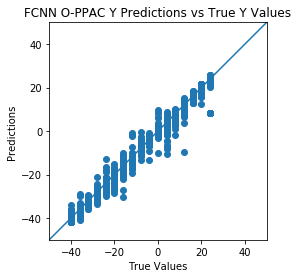

In [81]:
a = plt.axes(aspect='equal')
plt.scatter(new_y_labels, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title("FCNN O-PPAC Y Predictions vs True Y Values")